# Import function

In [1]:
import numpy as np
# import awkward
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')
import numpy as np
import scipy.optimize as opt
import sys, os, random, gzip
import tensorflow as tf
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import keras
import pandas as pd

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from sklearn.model_selection import train_test_split
import sys
from sklearn import metrics
from keras.models import load_model
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc as skAUC
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard
import tensorflow as tf
from keras import backend as K
import time
import glob
from tqdm import tqdm

In [3]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def roc_plot(N, validation_split, model_name):
    dependencies = {'auc': auc}
    model = load_model(f'models/{model_name}.h5', custom_objects=dependencies)
    X_train, X_test, y_train, y_true = prep_data(N, validation_split)
    y_score=model.predict(X_test).T[0]  
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    bkg_eff = fpr
    sig_eff = tpr
    auc_val = roc_auc_score(y_true, y_score)
    bkg_rej = 1. - bkg_eff
    inv_bkg = np.divide(1.0, bkg_eff)
    print(model_name, auc_val)
    plt.plot(sig_eff, inv_bkg , linestyle='-', label=f'{model_name} - [AUC={auc_val:0.3}]', linewidth=2)
    plt.xlabel('Signal Efficiency')
    plt.yscale('log')
    plt.ylabel('Inverse Background Efficiency')
    plt.xlim([0,1])
    plt.legend()
    plt.savefig(f'figures/roc.png')
    
def prep_data(N, validation_split):
    f = h5py.File('data/jet_complete.h5', 'r')
    X = f['features'][:N]
    y = f['targets'][:N]
    X = np.log(1.0+X) / 4.0 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_split)
    #reshape data to fit model
    X_train, X_test = X_train.reshape(len(X_train),32,32,1), X_test.reshape(len(X_test),32,32,1)
    return X_train, X_test, y_train, y_test

def train_nn(N, batch_size, epochs, validation_split):
    model_name = f'svj_N_{N}_b_{batch_size}_e_{epochs}_v_{validation_split}'
    X_train, X_test, y_train, y_test = prep_data(N, validation_split)
    #create model
    model = Sequential()
    #add model layers
    model.add(Conv2D(256, kernel_size=(4,4), border_mode='valid', init='glorot_normal', activation='relu', input_shape=(32,32,1)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, kernel_size=(4,4), border_mode='valid', init='glorot_normal', activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[auc, 'acc'])

    mc = ModelCheckpoint(f'models/{model_name}.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    cl = CSVLogger(f'history/{model_name}.log', separator=',', append=False)
    tb = TensorBoard(log_dir='./logs/'+ str(model_name), histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
    #es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto', baseline=None, restore_best_weights=False)


    #train the model
    model.fit(X_train, y_train, 
                batch_size=batch_size, 
                epochs=epochs, 
                verbose=2, 
                #validation_split=validation_split,
                validation_data=(X_test, y_test),
                callbacks=[cl, tb]
                )
    model.save(f'models/{model_name}.h5') 


if __name__ == "__main__":    
    #train_nn(N=500000, batch_size=256, epochs=500, validation_split=0.2)
    files = glob.glob('models/svj_*')
    for file in files:
        model_name = file.split('/')[-1].split('.h5')[0]
        details = model_name.split('_')    
        roc_plot(int(details[2]), float(details[-1]), model_name)

# Load data CNN

In [60]:
# f = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/SVJ/0jetim.h5",'r')
# f = f['jetim'][()]
# f2 = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/QCD/0jetim.h5",'r')
# f2 = f2['jetim'][()]
f = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/SVJ/0JSS_Jim.h5",'r')
f = f['Jet_im_my'][()]
f2 = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/QCD/0JSS_Jim.h5",'r')
f2 = f2['Jet_im_my'][()]

In [4]:
N=40
Jim = np.array([np.zeros((64,64))])
Jim2 = np.array([np.zeros((64,64))])

for i in tqdm(range(N)):
    f = h5py.File("/home/ja2006203966/script/Network/data/H5/SVJ/rinv03/"+str(i)+"JSS_Jim.h5",'r')
#     f = f['jetim'][()]
    fin = np.array(f['jetim_index'][()])
    fsin = set(f['jss_index'][()])
    fc = [(i in fsin) for i in fin]
    fim = f['jetim'][()]
    # fim = [i for i in fim]
    fim = [fim[i] for i in range(len(fc)) if fc[i]]
    
    
    
    f2 = h5py.File("/home/ja2006203966/script/Network/data/H5/QCD/"+str(i)+"JSS_Jim.h5",'r')
#     f2 = f2['jetim'][()]
    fin2 = np.array(f2['jetim_index'][()])
    fsin2 = set(f2['jss_index'][()])
    fc2 = [(i in fsin2) for i in fin2]
    fim2 = f2['jetim'][()]
    fim2 =  [fim2[i] for i in range(len(fc2)) if fc2[i]]
    
    Jim = np.append(Jim,fim, axis=0)
    Jim2 = np.append(Jim2,fim2, axis=0)



100%|██████████| 40/40 [03:12<00:00,  4.80s/it]


In [5]:
print(len(Jim), len(Jim2))

199742 354359


In [7]:
f = np.array([Jim[i] for i in range(199001) if np.sum(Jim[i])!=0])
f2 = np.array([Jim2[i] for i in range(199001) if np.sum(Jim2[i])!=0])

In [8]:
print(f.shape,f2.shape)

(199000, 64, 64) (199000, 64, 64)


In [9]:
ft = np.append(f,f2, axis=0)
# ft = np.append(Jim,Jim2, axis=0)

In [10]:
yt = np.array([1 for i in range(len(f))]+[0 for i in range(len(f2))])

In [11]:
from sklearn.model_selection import train_test_split
Xim_train, Xim_val, yim_train, yim_val = train_test_split(ft, yt, test_size=0.4)
Xim_val, Xim_test, yim_val, yim_test = train_test_split(Xim_val, yim_val, test_size=0.25)

In [12]:
print("training size: ",len(Xim_train)," val size: ",len(Xim_val), "test size:", len(Xim_test))

training size:  238800  val size:  119400 test size: 39800


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


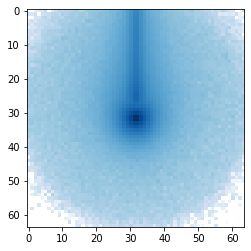

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


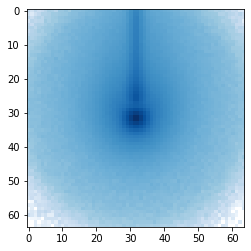

In [13]:
X = np.sum(f2, axis=0)
plt.imshow(np.log(X), cmap='Blues', label = 'QCD', filternorm=1)
plt.show()
Y = np.sum(f, axis=0)
plt.imshow(np.log(Y), cmap='Blues', label = 'SVJ', filternorm=1)
plt.show()

# Model CNN

In [14]:
inputs = tf.keras.Input(shape=(64,64))
x = inputs
x = tf.expand_dims(x,axis=-1)
print(x.shape)
x = tf.keras.layers.Conv2D(32, kernel_size=(1,1), activation='relu', input_shape=(64,64,1))(x)
print(x.shape)
# x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
# print(x.shape)
x = tf.keras.layers.Conv2D(64, kernel_size=(4,4), activation='relu', input_shape=(64,64,32))(x)
print(x.shape)
x = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))(x)
print(x.shape)

x = tf.keras.layers.Conv2D(128, kernel_size=(4,4), activation='relu', input_shape=(15,15,64))(x)
print(x.shape)
x = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))(x)
print(x.shape)

x = tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', input_shape=(3,3,128))(x)
print(x.shape)

x = tf.keras.layers.Flatten()(x)
print(x.shape)
x = tf.keras.layers.Dense(128, activation='relu')(x)
print(x.shape)
x = tf.keras.layers.Dropout(0.2)(x)
print(x.shape)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)
print(x.shape)
modelCNN = tf.keras.Model(inputs=inputs, outputs=x, name='CNN')


(None, 64, 64, 1)
(None, 64, 64, 32)
(None, 61, 61, 64)
(None, 15, 15, 64)
(None, 12, 12, 128)
(None, 3, 3, 128)
(None, 1, 1, 256)
(None, 256)
(None, 128)
(None, 128)
(None, 2)


In [131]:
# inputs = tf.keras.Input(shape=(64,64))
# x = inputs
# x = tf.expand_dims(x,axis=-1)
# x = tf.keras.layers.Conv2D(64, kernel_size=(1,1), activation='relu', input_shape=(64,64,1))(x)
# # x = tf.keras.layers.MaxPooling2D()(x)
# x = tf.keras.layers.AveragePooling2D()(x)
# x = tf.keras.layers.Conv2D(256, kernel_size=(4,4), activation='relu')(x)
# # x = tf.keras.layers.MaxPooling2D()(x)
# x = tf.keras.layers.AveragePooling2D()(x)


# x = tf.keras.layers.Flatten()(x)
# # x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(2, activation='sigmoid')(x)
# modelCNN = tf.keras.Model(inputs=inputs, outputs=x, name='CNN')

In [15]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
modelCNN.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
modelCNN.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64)]          0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        32832     
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       131200    
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 128)         0       

In [16]:
outfile = "/home/ja2006203966/script/Network/data/H5/CNN/Train.h5"
hf = h5py.File(outfile, 'w')
hf.create_dataset('X_train', data=Xim_train)
hf.create_dataset('y_train', data=yim_train)
hf.create_dataset('X_val', data=Xim_val)
hf.create_dataset('y_val', data=yim_val)
hf.create_dataset('X_test', data=Xim_test)
hf.create_dataset('y_test', data=yim_test)
hf.close()

In [6]:
outfile = "/home/ja2006203966/script/Network/data/H5/CNN/Train.h5"
hf = h5py.File(outfile, 'r')
Xim_train = hf["X_train"][()]
yim_train = hf["y_train"][()]
Xim_val = hf["X_val"][()]
yim_val = hf["y_val"][()]
Xim_test = hf["X_test"][()]
yim_test = hf["y_test"][()]
hf.close()



In [17]:
model_type = "CNN"
save_dir = '/home/ja2006203966/script/Network/data/H5/CNN/'
model_name = '%s_model.test.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

# lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

# progress_bar = keras.callbacks.ProgbarLogger()
csv_logger = keras.callbacks.CSVLogger(save_dir+'CNN.csv')
earlystop = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=1e-4,
                            patience=3,
                            verbose=1,
                            mode='min', baseline=None, ## 'min' 
                            restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=0.00001)
callbacks = [checkpoint, csv_logger,  earlystop ]


In [18]:
hist = modelCNN.fit(Xim_train, yim_train , validation_data=(Xim_val, yim_val), callbacks = callbacks, shuffle=True , epochs=20)

Epoch 1/20
7463/7463 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.7627

[2020-08-04 08:16:56,608] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 77s 10ms/step - loss: 0.5362 - accuracy: 0.7627 - val_loss: 0.5278 - val_accuracy: 0.7687
Epoch 2/20
7461/7463 [============================>.] - ETA: 0s - loss: 0.5261 - accuracy: 0.7729

[2020-08-04 08:18:13,833] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 77s 10ms/step - loss: 0.5261 - accuracy: 0.7729 - val_loss: 0.5229 - val_accuracy: 0.7764
Epoch 3/20
7460/7463 [============================>.] - ETA: 0s - loss: 0.5225 - accuracy: 0.7772

[2020-08-04 08:19:31,599] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5225 - accuracy: 0.7772 - val_loss: 0.5224 - val_accuracy: 0.7758
Epoch 4/20
7463/7463 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.7803

[2020-08-04 08:20:49,573] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5194 - accuracy: 0.7803 - val_loss: 0.5194 - val_accuracy: 0.7796
Epoch 5/20
7461/7463 [============================>.] - ETA: 0s - loss: 0.5168 - accuracy: 0.7834

[2020-08-04 08:22:07,579] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5168 - accuracy: 0.7834 - val_loss: 0.5182 - val_accuracy: 0.7804
Epoch 6/20
7461/7463 [============================>.] - ETA: 0s - loss: 0.5148 - accuracy: 0.7857

[2020-08-04 08:23:25,350] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5148 - accuracy: 0.7857 - val_loss: 0.5250 - val_accuracy: 0.7760
Epoch 7/20
7457/7463 [============================>.] - ETA: 0s - loss: 0.5136 - accuracy: 0.7869

[2020-08-04 08:24:43,407] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5136 - accuracy: 0.7869 - val_loss: 0.5180 - val_accuracy: 0.7810
Epoch 8/20
7457/7463 [============================>.] - ETA: 0s - loss: 0.5119 - accuracy: 0.7891

[2020-08-04 08:26:01,257] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5119 - accuracy: 0.7892 - val_loss: 0.5163 - val_accuracy: 0.7836
Epoch 9/20
7460/7463 [============================>.] - ETA: 0s - loss: 0.5109 - accuracy: 0.7900

[2020-08-04 08:27:18,727] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 77s 10ms/step - loss: 0.5109 - accuracy: 0.7900 - val_loss: 0.5140 - val_accuracy: 0.7855
Epoch 10/20
7457/7463 [============================>.] - ETA: 0s - loss: 0.5094 - accuracy: 0.7917

[2020-08-04 08:28:36,165] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 77s 10ms/step - loss: 0.5094 - accuracy: 0.7917 - val_loss: 0.5204 - val_accuracy: 0.7786
Epoch 11/20
7462/7463 [============================>.] - ETA: 0s - loss: 0.5084 - accuracy: 0.7930

[2020-08-04 08:29:53,540] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 77s 10ms/step - loss: 0.5084 - accuracy: 0.7930 - val_loss: 0.5185 - val_accuracy: 0.7827
Epoch 12/20
7462/7463 [============================>.] - ETA: 0s - loss: 0.5075 - accuracy: 0.7938

[2020-08-04 08:31:11,658] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5075 - accuracy: 0.7938 - val_loss: 0.5134 - val_accuracy: 0.7864
Epoch 13/20
7457/7463 [============================>.] - ETA: 0s - loss: 0.5065 - accuracy: 0.7951

[2020-08-04 08:32:29,206] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5066 - accuracy: 0.7951 - val_loss: 0.5147 - val_accuracy: 0.7862
Epoch 14/20
7457/7463 [============================>.] - ETA: 0s - loss: 0.5053 - accuracy: 0.7970

[2020-08-04 08:33:46,737] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5053 - accuracy: 0.7970 - val_loss: 0.5135 - val_accuracy: 0.7867
Epoch 15/20
7463/7463 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.7981

[2020-08-04 08:35:05,137] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 11ms/step - loss: 0.5042 - accuracy: 0.7981 - val_loss: 0.5127 - val_accuracy: 0.7864
Epoch 16/20
7461/7463 [============================>.] - ETA: 0s - loss: 0.5036 - accuracy: 0.7988

[2020-08-04 08:36:22,752] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5036 - accuracy: 0.7988 - val_loss: 0.5127 - val_accuracy: 0.7875
Epoch 17/20
7459/7463 [============================>.] - ETA: 0s - loss: 0.5024 - accuracy: 0.8008

[2020-08-04 08:37:40,285] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5025 - accuracy: 0.8008 - val_loss: 0.5149 - val_accuracy: 0.7860
Epoch 18/20
7463/7463 [==============================] - ETA: 0s - loss: 0.5018 - accuracy: 0.8014

[2020-08-04 08:38:58,038] WARNING: Can save best model only with val_acc available, skipping.


Restoring model weights from the end of the best epoch.
7463/7463 [==============================] - 78s 10ms/step - loss: 0.5018 - accuracy: 0.8014 - val_loss: 0.5146 - val_accuracy: 0.7862
Epoch 00018: early stopping


In [19]:
from sklearn.metrics import roc_curve, auc

The area under the curves are:
AUC:0.856311747


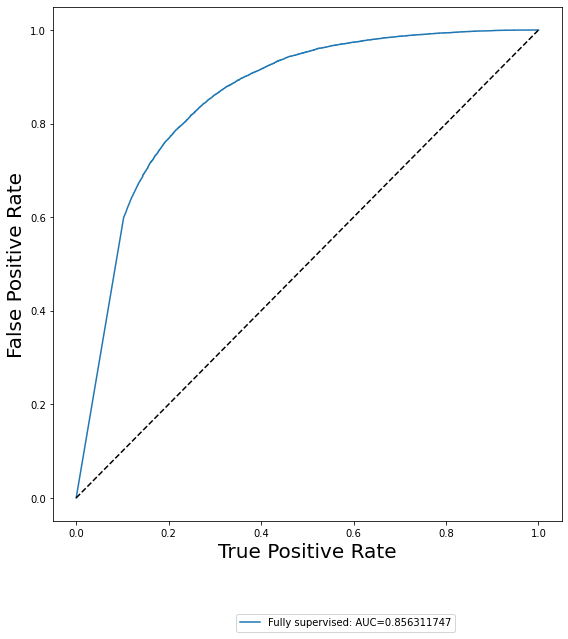

In [20]:
y_score=modelCNN.predict(Xim_test)[:,0]
# test=[i[1] for i in yim_test]
fpr , tpr , thresholds = roc_curve ( yim_test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("/home/ja2006203966/script/Network/data/H5/CNN/CNN_roc.png")
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/CNN/PR.h5", 'w')
hf.create_dataset('fpr', data=fpr)
hf.create_dataset('tpr', data=tpr)
hf.close()
# np.save("./myfpr",fpr)
# np.save("./mytpr",tpr)
plt.show()

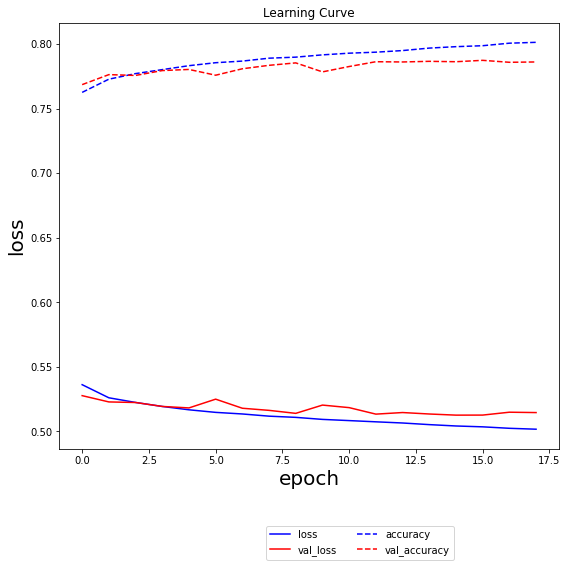

In [21]:
plt.figure(figsize=(8,8))
LOSS = pd.read_csv(save_dir+"CNN.csv")
plt.title("Learning Curve")
plt.plot(LOSS["loss"], label='loss',c='blue')
plt.plot(LOSS["val_loss"], label='val_loss',c='red')
plt.plot(LOSS["accuracy"], linestyle='--', label='accuracy',c='blue')
plt.plot(LOSS["val_accuracy"], linestyle='--', label='val_accuracy',c='red')
# plt.ylim([0.3,1])
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("/home/ja2006203966/script/Network/data/H5/CNN/CNNloss.png")

plt.show()

In [22]:
modelCNN.save('/home/ja2006203966/script/Network/data/H5/CNN/modelCNN.h5')

# Load data DNN

In [47]:
f = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/SVJ/0JSS_Jim.h5",'r')
f2 = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/QCD/0JSS_Jim.h5",'r')


In [4]:
Labels = ['T21', 'D21', 'MASS', 'D22', 'C22', 'C21']

In [29]:
JSS2 = []
N = 40
Labels = ['MASS', 'T21', 'C22', 'C21',  'D22', 'D21']
JSSd = {'MASS':[], 'T21':[], 'C22':[], 'C21':[],  'D22':[], 'D21':[]}
JSSd2 = {'MASS':[], 'T21':[], 'C22':[], 'C21':[],  'D22':[], 'D21':[]}

for lb in Labels:
    for i in range(N):
        jss = h5py.File("/home/ja2006203966/script/Network/data/H5/SVJ/rinv03/"+str(i)+"JSS_Jim.h5",'r')
        jss = jss[lb][()].tolist()
        JSSd[lb] = JSSd[lb] + jss
        
        jss2 = h5py.File("/home/ja2006203966/script/Network/data/H5/QCD/"+str(i)+"JSS_Jim.h5",'r')
        jss2 = jss2[lb][()].tolist()
        JSSd2[lb] = JSSd2[lb] + jss2

In [34]:
f.shape

(199000, 6)

In [31]:
f = np.array([ JSSd[i] for i in Labels])
f2 = np.array([ JSSd2[i] for i in Labels])
f = f.transpose((1,0))
f2 = f2.transpose((1,0))

In [33]:
f = np.array([f[i] for i in range(199000)])
f2 = np.array([f2[i] for i in range(199000)])

In [35]:
ft = np.append(f,f2, axis=0)

In [36]:
yt = np.array([1 for i in range(len(f))]+[0 for i in range(len(f2))])

In [37]:
ft.shape

(398000, 6)

## Seperate data

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(ft, yt, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.25)

## Save training data

In [39]:
# outfile = "/home/ja2006203966/script/Network/data/H5/DNN/Train.h5"
# hf = h5py.File(outfile, 'w')
# hf.create_dataset('X_train', data=X_train)
# hf.create_dataset('y_train', data=y_train)
# hf.create_dataset('X_val', data=X_val)
# hf.create_dataset('y_val', data=y_val)
# hf.create_dataset('X_test', data=X_test)
# hf.create_dataset('y_test', data=y_test)
# hf.close()

## Load data

In [14]:
outfile = "/home/ja2006203966/script/Network/data/H5/DNN/Train.h5"
hf = h5py.File(outfile, 'r')
X_train = hf["X_train"][()]
y_train = hf["y_train"][()]
X_val = hf["X_val"][()]
y_val = hf["y_val"][()]
X_test = hf["X_test"][()]
y_test = hf["y_test"][()]
hf.close()



In [16]:
inputs*w1

<tf.Tensor 'Mul:0' shape=(None, 6) dtype=float32>

# Model DNN

In [23]:
class MyLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(MyLayer, self).__init__()
        
        #your variable goes here
        self.variable = tf.Variable(1., trainable=True, dtype=tf.float64)
        
    def call(self, inputs, **kwargs):
        
        # your mul operation goes here
        x = inputs * self.variable
        
        return x

In [24]:
class Dense(tf.keras.layers.Layer):
    def __init__(self, units=6):
        super(Linear, self).__init__()
        self.units = units
    def build(self, input_shape):  # Create the state of the layer (weights)
#         w_init = tf.random_normal_initializer()
#         w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value= tf.ones(shape=(input_shape[-1], self.units),
                                 dtype='float32'),
            trainable=True)
#         b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=tf.zeros(shape=(input_shape[-1], self.units), dtype='float32'),
            trainable=True)
    def call(self, inputs):  # Defines the computation from inputs to outputs
#         return tf.matmul(inputs, self.w) + self.b
        return tf.matmul(inputs, self.w) + self.b




In [45]:
w1 = tf.Variable(initial_value=tf.zeros(shape=(6,1), dtype='float32'), trainable=True)

In [46]:
print(inputs.shape, w1.shape)

(None, 6) (6, 1)


In [47]:
tf.matmul(inputs, w1)

<tf.Tensor 'MatMul_2:0' shape=(None, 1) dtype=float32>

In [63]:
inputs.input_shape

AttributeError: 'Tensor' object has no attribute 'input_shape'

In [32]:
tf.random_normal_initializer((6,))

In [40]:
inputs = tf.keras.Input(shape=(6,))
x = inputs
# x = Linear(x.shape[-1])(x)
x = tf.keras.layers.Dense(6, activation='relu')(x)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)
modelDNN = tf.keras.Model(inputs=inputs, outputs=x, name='DNN')

In [41]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
modelDNN.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
modelDNN.summary()

Model: "DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1792      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 2,348
Trainable params: 2,348
Non-trainable params: 0
_________________________________________________________________


In [42]:
model_type = "DNN"
save_dir = '/home/ja2006203966/script/Network/data/H5/DNN/'
model_name = '%s_model.test.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

# lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

# progress_bar = keras.callbacks.ProgbarLogger()
csv_logger = keras.callbacks.CSVLogger(save_dir+'DNN.csv')
earlystop = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=1e-4,
                            patience=3,
                            verbose=1,
                            mode='min', baseline=None, ## 'min' 
                            restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=0.00001)
callbacks = [checkpoint, csv_logger,  earlystop ]


In [43]:
modelDNN.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=callbacks, shuffle=True , epochs=20)

Epoch 1/20
7450/7463 [============================>.] - ETA: 0s - loss: 0.6341 - accuracy: 0.6177

[2020-08-04 08:53:21,667] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 36s 5ms/step - loss: 0.6341 - accuracy: 0.6177 - val_loss: 0.6327 - val_accuracy: 0.6406
Epoch 2/20
7452/7463 [============================>.] - ETA: 0s - loss: 0.6313 - accuracy: 0.5504

[2020-08-04 08:53:57,983] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 36s 5ms/step - loss: 0.6313 - accuracy: 0.5504 - val_loss: 0.6304 - val_accuracy: 0.5005
Epoch 3/20
7450/7463 [============================>.] - ETA: 0s - loss: 0.6294 - accuracy: 0.4989

[2020-08-04 08:54:34,861] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 37s 5ms/step - loss: 0.6294 - accuracy: 0.4989 - val_loss: 0.6268 - val_accuracy: 0.5005
Epoch 4/20
7450/7463 [============================>.] - ETA: 0s - loss: 0.5692 - accuracy: 0.6711

[2020-08-04 08:55:10,780] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 36s 5ms/step - loss: 0.5692 - accuracy: 0.6712 - val_loss: 0.5358 - val_accuracy: 0.7618
Epoch 5/20
7463/7463 [==============================] - ETA: 0s - loss: 0.5356 - accuracy: 0.7624

[2020-08-04 08:55:47,299] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 37s 5ms/step - loss: 0.5356 - accuracy: 0.7624 - val_loss: 0.5359 - val_accuracy: 0.7624
Epoch 6/20
7452/7463 [============================>.] - ETA: 0s - loss: 0.5341 - accuracy: 0.7637

[2020-08-04 08:56:23,468] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 36s 5ms/step - loss: 0.5341 - accuracy: 0.7637 - val_loss: 0.5418 - val_accuracy: 0.7563
Epoch 7/20
7456/7463 [============================>.] - ETA: 0s - loss: 0.5341 - accuracy: 0.7644

[2020-08-04 08:56:59,599] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 36s 5ms/step - loss: 0.5341 - accuracy: 0.7643 - val_loss: 0.5326 - val_accuracy: 0.7652
Epoch 8/20
7449/7463 [============================>.] - ETA: 0s - loss: 0.5337 - accuracy: 0.7644

[2020-08-04 08:57:35,795] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 36s 5ms/step - loss: 0.5337 - accuracy: 0.7644 - val_loss: 0.5369 - val_accuracy: 0.7606
Epoch 9/20
7463/7463 [==============================] - ETA: 0s - loss: 0.5340 - accuracy: 0.7641

[2020-08-04 08:58:12,141] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 36s 5ms/step - loss: 0.5340 - accuracy: 0.7641 - val_loss: 0.5335 - val_accuracy: 0.7648
Epoch 10/20
7452/7463 [============================>.] - ETA: 0s - loss: 0.5331 - accuracy: 0.7655

[2020-08-04 08:58:47,865] WARNING: Can save best model only with val_acc available, skipping.


Restoring model weights from the end of the best epoch.
7463/7463 [==============================] - 36s 5ms/step - loss: 0.5331 - accuracy: 0.7655 - val_loss: 0.5331 - val_accuracy: 0.7649
Epoch 00010: early stopping


In [44]:
from sklearn.metrics import roc_curve, auc

The area under the curves are:
AUC:0.842117566


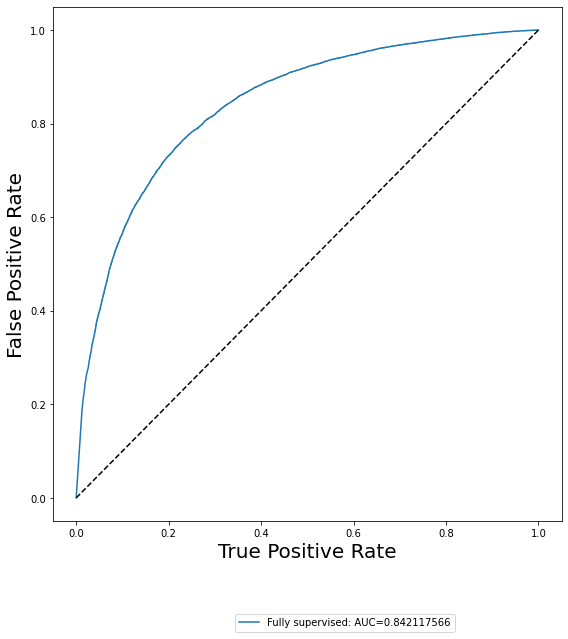

In [45]:
y_score=modelDNN.predict(X_test)[:,0]
# test=[i[1] for i in yim_test]
fpr , tpr , thresholds = roc_curve ( y_test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("/home/ja2006203966/script/Network/data/H5/DNN/DNN_roc.png")
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/DNN/PR.h5", 'w')
hf.create_dataset('fpr', data=fpr)
hf.create_dataset('tpr', data=tpr)
hf.close()
# np.save("./myfpr",fpr)
# np.save("./mytpr",tpr)
plt.show()

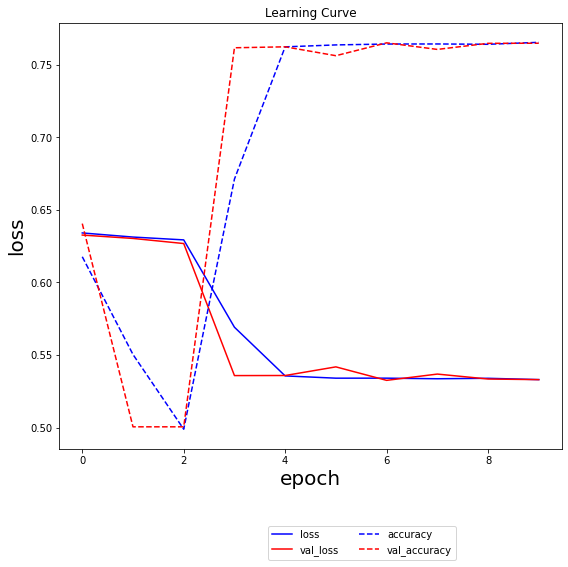

In [46]:
plt.figure(figsize=(8,8))
LOSS = pd.read_csv(save_dir+"DNN.csv")
plt.title("Learning Curve")
plt.plot(LOSS["loss"], label='loss',c='blue')
plt.plot(LOSS["val_loss"], label='val_loss',c='red')
plt.plot(LOSS["accuracy"], linestyle='--', label='accuracy',c='blue')
plt.plot(LOSS["val_accuracy"], linestyle='--', label='val_accuracy',c='red')
# plt.ylim([0.3,1])
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("/home/ja2006203966/script/Network/data/H5/DNN/DNNloss.png")

plt.show()

In [47]:
modelDNN.save('/home/ja2006203966/script/Network/data/H5/DNN/modelDNN.h5')

# Load 2CNN data

In [48]:
N=40
# Jim = np.array([np.zeros((64,64))])
# Jim2 = np.array([np.zeros((64,64))])
Jim = []
Jim2 = []
JSSd = {'MASS':[], 'T21':[], 'C22':[], 'C21':[],  'D22':[], 'D21':[]}
JSSd2 = {'MASS':[], 'T21':[], 'C22':[], 'C21':[],  'D22':[], 'D21':[]}
Labels = ['MASS', 'T21', 'C22', 'C21',  'D22', 'D21']
for i in tqdm(range(N)):
    f = h5py.File("/home/ja2006203966/script/Network/data/H5/SVJ/rinv03/"+str(i)+"JSS_Jim.h5",'r')
    
    fin = np.array(f['jetim_index'][()])
    fsin = np.array(f['jss_index'][()])
    fcin = set(f['jss_index'][()])&set(f['jetim_index'][()])
    fci = [(i in fcin) for i in fin]
    fcs = [(i in fcin) for i in fsin]

    fim = f['jetim'][()]
    # fim = [i for i in fim]
    fim = [fim[i] for i in range(len(fci)) if fci[i]]
    
    f2 = h5py.File("/home/ja2006203966/script/Network/data/H5/QCD/"+str(i)+"JSS_Jim.h5",'r')
    fin2 = np.array(f2['jetim_index'][()])
    fsin2 = np.array(f2['jss_index'][()])
    fcin2 = set(f2['jss_index'][()])&set(f2['jetim_index'][()])
    fci2 = [(i in fcin2) for i in fin2]
    fcs2 = [(i in fcin2) for i in fsin2]
    
    fim2 = f2['jetim'][()]
    fim2 =  [fim2[i] for i in range(len(fci2)) if fci2[i]]
    
    Jim = Jim +fim
    Jim2 = Jim2+fim2
#     Jim = np.append(Jim,fim, axis=0)
#     Jim2 = np.append(Jim2,fim2, axis=0)
    
    for lb in Labels:
        jss = [f[lb][()][i] for i in range(len(fcs)) if fcs[i]]
#         jss = f[lb][()].tolist()
        JSSd[lb] = JSSd[lb] + jss
        
        jss2 = [f2[lb][()][i] for i in range(len(fcs2)) if fcs2[i]]

#         jss2 = f2[lb][()].tolist()
        JSSd2[lb] = JSSd2[lb] + jss2
    
    
    
    
    



100%|██████████| 40/40 [15:35<00:00, 23.39s/it]


In [49]:
fs = np.array([ JSSd[i] for i in Labels])
fs2 = np.array([ JSSd2[i] for i in Labels])
fs = fs.transpose((1,0))
fs2 = fs2.transpose((1,0))
fi = np.array(Jim)
fi2 = np.array(Jim2)

In [50]:
(fs.shape,fi.shape, fs2.shape, fi2.shape)

((199741, 6), (199741, 64, 64), (354358, 6), (354358, 64, 64))

In [51]:
fs = np.array([fs[i] for i in range(199000) ])
fs2 = np.array([fs2[i] for i in range(199000) ])
fi = np.array([fi[i] for i in range(199000) ])
fi2 = np.array([fi2[i] for i in range(199000) ])

In [52]:
ft = np.append(fs,fs2, axis=0)
ftim = np.append(fi,fi2, axis=0)

In [53]:
yt = np.array([1 for i in range(len(fs))]+[0 for i in range(len(fs2))])

In [54]:
yt.shape

(398000,)

In [55]:
fc = np.array([(ft[i],ftim[i]) for i in range(len(ft))])

In [56]:
fc[0][0].shape

(6,)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(fc, yt, test_size=0.4)
# X_train, X_val, y_train, y_val = train_test_split(ft, yt, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.25)

In [58]:
X_train1 = X_train.transpose(1,0)[0]
X_train2 = X_train.transpose(1,0)[1]
X_val1 = X_val.transpose(1,0)[0]
X_val2 = X_val.transpose(1,0)[1]
X_test1 = X_test.transpose(1,0)[0]
X_test2 = X_test.transpose(1,0)[1]

In [59]:
X_train1 = np.array([i for i in X_train1])
X_train2 = np.array([i for i in X_train2])
X_val1 = np.array([i for i in X_val1])
X_val2 = np.array([i for i in X_val2])
X_test1 = np.array([i for i in X_test1])
X_test2 = np.array([i for i in X_test2])

In [60]:
X_train1.shape

(238800, 6)

## Save Training data

In [61]:
outfile = "/home/ja2006203966/script/Network/data/H5/2CNN/Train.h5"
hf = h5py.File(outfile, 'w')
hf.create_dataset('X_train_jss', data=X_train1)
hf.create_dataset('X_val_jss', data=X_val1)
hf.create_dataset('X_test_jss', data=X_test1)
hf.create_dataset('X_train_jim', data=X_train2)
hf.create_dataset('X_val_jim', data=X_val2)
hf.create_dataset('X_test_jim', data=X_test2)

hf.create_dataset('y_train', data=y_train)
hf.create_dataset('y_val', data=y_val)
hf.create_dataset('y_test', data=y_test)
hf.close()

# Model 2CNN

## Load data

In [3]:
outfile = "/home/ja2006203966/script/Network/data/H5/2CNN/Train.h5"
hf = h5py.File(outfile, 'r')
X_train1 = hf["X_train_jss"][()]
X_val1 = hf["X_val_jss"][()]
X_test1 = hf["X_test_jss"][()]
X_train2 = hf["X_train_jim"][()]
X_val2 = hf["X_val_jim"][()]
X_test2 = hf["X_test_jim"][()]


y_train = hf["y_train"][()]
y_val = hf["y_val"][()]
y_test = hf["y_test"][()]

hf.close()

In [148]:
inputs = tf.keras.Input(shape=(6,))
x = inputs
x = tf.keras.layers.Dense(36, activation='relu')(x)

# x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(1)(x)

inputs2 = tf.keras.Input(shape=(64,64))
x2 = inputs2
x2 = tf.expand_dims(x2,axis=-1)
x2 = tf.keras.layers.Conv2D(256, kernel_size=(1,1), activation='relu', input_shape=(64,64,1))(x2)
# x2 = tf.keras.layers.MaxPooling2D()(x2)
x2 = tf.keras.layers.AveragePooling2D()(x2)
x2 = tf.keras.layers.Conv2D(128, kernel_size=(4,4), activation='relu')(x2)
# x2 = tf.keras.layers.MaxPooling2D()(x2)
x2 = tf.keras.layers.AveragePooling2D()(x2)
x2 = tf.keras.layers.Flatten()(x2)
# x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
# x2 = tf.keras.layers.Dropout(0.2)(x2)
# x2 = tf.keras.layers.Dense(1)(x2)

xt = tf.concat([x,x2], axis=-1)
xt = tf.keras.layers.Dense(128, activation='relu')(xt)
xt = tf.keras.layers.Dropout(0.2)(xt)
xt = tf.keras.layers.Dense(2, activation='sigmoid')(xt)




model2CNN = tf.keras.Model(inputs=(inputs, inputs2), outputs=xt, name='2CNN')

In [4]:
class Linear(Layer):
    def __init__(self, units=1):
        super(Linear, self).__init__()
        self.units = units
        
    def build(self, input_shape):  # Create the state of the layer (weights)
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_shape[-1], self.units), dtype='float32'), trainable=True)
        
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(initial_value=b_init(shape=(self.units,), dtype='float32'), trainable=True)
        
    def call(self, inputs):  # Defines the computation from inputs to outputs
        
        return tf.matmul(inputs, self.w) + self.b
   

In [26]:
inputs2 = tf.keras.Input(shape=(6,))
x2 = inputs2
print('model2',x2.shape)
x2 = tf.expand_dims(x2,axis=-1)
print(x2.shape)
x2 = Linear()(x2)
print(x2.shape)

model2 (None, 6)
(None, 6, 1)
(None, 6, 1)


In [5]:
inputs = tf.keras.Input(shape=(64,64))
x = inputs
x = tf.expand_dims(x,axis=-1)
print(x.shape)
x = tf.keras.layers.Conv2D(32, kernel_size=(1,1), activation='relu', input_shape=(64,64,1))(x)
print(x.shape)
# x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
# print(x.shape)
x = tf.keras.layers.Conv2D(64, kernel_size=(4,4), activation='relu', input_shape=(64,64,32))(x)
print(x.shape)
x = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))(x)
print(x.shape)

x = tf.keras.layers.Conv2D(128, kernel_size=(4,4), activation='relu', input_shape=(15,15,64))(x)
print(x.shape)
x = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))(x)
print(x.shape)

x = tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', input_shape=(3,3,128))(x)
print(x.shape)

x = tf.keras.layers.Flatten()(x)
print(x.shape)


inputs2 = tf.keras.Input(shape=(6,))
x2 = inputs2
print('model2',x2.shape)

# x2 = tf.keras.layers.Dense(6, activation='relu')(x2)
# print('model2',x2.shape)
# x2 = tf.expand_dims(x2,axis=-1)
# print('model2',x2.shape)
# x2 = Linear()(x2)
# print('model2',x2.shape)
# x2 = tf.keras.layers.Flatten()(x2)
# print('model2',x2.shape)

xt = tf.concat([x,x2], axis=-1)
print('modelt', xt.shape)
xt = tf.keras.layers.Dense(128, activation='relu')(xt)
print('modelt', xt.shape)
xt = tf.keras.layers.Dropout(0.2)(xt)
print('modelt', xt.shape)
xt = tf.keras.layers.Dense(2, activation='sigmoid')(xt)
print('modelt', xt.shape)

model2CNN = tf.keras.Model(inputs=(inputs2, inputs), outputs=xt, name='2CNN')


(None, 64, 64, 1)
(None, 64, 64, 32)
(None, 61, 61, 64)
(None, 15, 15, 64)
(None, 12, 12, 128)
(None, 3, 3, 128)
(None, 1, 1, 256)
(None, 256)
model2 (None, 6)
modelt (None, 262)
modelt (None, 128)
modelt (None, 128)
modelt (None, 2)


In [6]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model2CNN.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model2CNN.summary()

Model: "2CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 64, 64, 1)]  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   64          tf_op_layer_ExpandDims[0][0]     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 61, 61, 64)   32832       conv2d[0][0]                     
_______________________________________________________________________________________________

In [7]:
model_type = "2CNN"
save_dir = '/home/ja2006203966/script/Network/data/H5/2CNN/'
model_name = '%s_model.test.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

# lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

# progress_bar = keras.callbacks.ProgbarLogger()
csv_logger = keras.callbacks.CSVLogger(save_dir+'2CNN.csv')
earlystop = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=1e-4,
                            patience=3,
                            verbose=1,
                            mode='min', baseline=None, ## 'min' 
                            restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=0.00001)
callbacks = [checkpoint, csv_logger,  earlystop ]


In [8]:
model2CNN.fit((X_train1,X_train2), y_train, callbacks = callbacks, validation_data=((X_val1,X_val2), y_val), shuffle=True , epochs=20)

Epoch 1/20
7463/7463 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.7541

[2020-08-04 09:19:04,806] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5456 - accuracy: 0.7541 - val_loss: 0.5313 - val_accuracy: 0.7702
Epoch 2/20
7460/7463 [============================>.] - ETA: 0s - loss: 0.5331 - accuracy: 0.7672

[2020-08-04 09:20:23,040] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5331 - accuracy: 0.7672 - val_loss: 0.5274 - val_accuracy: 0.7738
Epoch 3/20
7461/7463 [============================>.] - ETA: 0s - loss: 0.5276 - accuracy: 0.7722

[2020-08-04 09:21:41,467] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 11ms/step - loss: 0.5276 - accuracy: 0.7722 - val_loss: 0.5249 - val_accuracy: 0.7742
Epoch 4/20
7457/7463 [============================>.] - ETA: 0s - loss: 0.5252 - accuracy: 0.7756

[2020-08-04 09:22:59,622] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5252 - accuracy: 0.7756 - val_loss: 0.5213 - val_accuracy: 0.7784
Epoch 5/20
7457/7463 [============================>.] - ETA: 0s - loss: 0.5229 - accuracy: 0.7774

[2020-08-04 09:24:17,674] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5229 - accuracy: 0.7774 - val_loss: 0.5188 - val_accuracy: 0.7823
Epoch 6/20
7460/7463 [============================>.] - ETA: 0s - loss: 0.5200 - accuracy: 0.7805

[2020-08-04 09:25:36,123] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 11ms/step - loss: 0.5200 - accuracy: 0.7805 - val_loss: 0.5187 - val_accuracy: 0.7813
Epoch 7/20
7462/7463 [============================>.] - ETA: 0s - loss: 0.5177 - accuracy: 0.7828

[2020-08-04 09:26:54,486] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5177 - accuracy: 0.7828 - val_loss: 0.5171 - val_accuracy: 0.7815
Epoch 8/20
7460/7463 [============================>.] - ETA: 0s - loss: 0.5161 - accuracy: 0.7851

[2020-08-04 09:28:13,623] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 79s 11ms/step - loss: 0.5161 - accuracy: 0.7851 - val_loss: 0.5180 - val_accuracy: 0.7838
Epoch 9/20
7460/7463 [============================>.] - ETA: 0s - loss: 0.5151 - accuracy: 0.7866

[2020-08-04 09:29:32,221] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 79s 11ms/step - loss: 0.5151 - accuracy: 0.7865 - val_loss: 0.5151 - val_accuracy: 0.7852
Epoch 10/20
7458/7463 [============================>.] - ETA: 0s - loss: 0.5137 - accuracy: 0.7876

[2020-08-04 09:30:51,163] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 79s 11ms/step - loss: 0.5137 - accuracy: 0.7876 - val_loss: 0.5137 - val_accuracy: 0.7867
Epoch 11/20
7463/7463 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.7888

[2020-08-04 09:32:10,868] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 80s 11ms/step - loss: 0.5124 - accuracy: 0.7888 - val_loss: 0.5142 - val_accuracy: 0.7846
Epoch 12/20
7463/7463 [==============================] - ETA: 0s - loss: 0.5114 - accuracy: 0.7904

[2020-08-04 09:33:29,105] WARNING: Can save best model only with val_acc available, skipping.


7463/7463 [==============================] - 78s 10ms/step - loss: 0.5114 - accuracy: 0.7904 - val_loss: 0.5163 - val_accuracy: 0.7846
Epoch 13/20
7462/7463 [============================>.] - ETA: 0s - loss: 0.5107 - accuracy: 0.7906

[2020-08-04 09:34:47,808] WARNING: Can save best model only with val_acc available, skipping.


Restoring model weights from the end of the best epoch.
7463/7463 [==============================] - 79s 11ms/step - loss: 0.5107 - accuracy: 0.7906 - val_loss: 0.5142 - val_accuracy: 0.7869
Epoch 00013: early stopping


In [9]:
model2CNN.save('/home/ja2006203966/script/Network/data/H5/2CNN/model2CNN.h5')

In [10]:
from sklearn.metrics import roc_curve, auc

The area under the curves are:
AUC:0.861165673


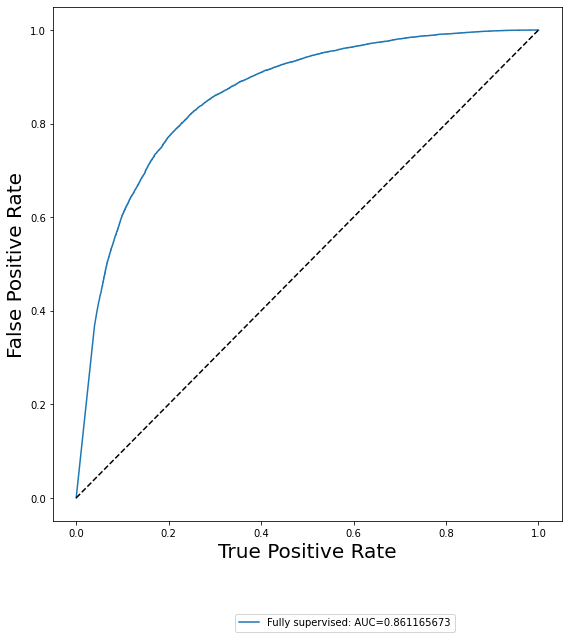

In [11]:
y_score=model2CNN.predict((X_test1,X_test2))[:,0]
# test=[i[1] for i in yim_test]
fpr , tpr , thresholds = roc_curve ( y_test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("/home/ja2006203966/script/Network/data/H5/2CNN/2CNN_roc.png")
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/2CNN/PR.h5", 'w')
hf.create_dataset('fpr', data=fpr)
hf.create_dataset('tpr', data=tpr)
hf.close()
# np.save("./myfpr",fpr)
# np.save("./mytpr",tpr)
plt.show()

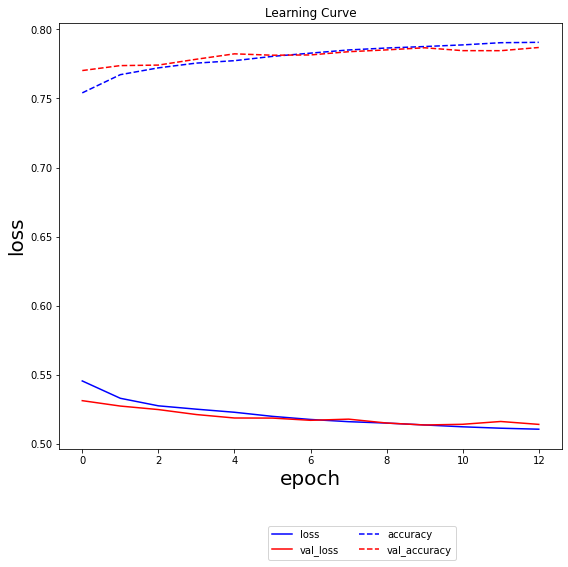

In [12]:
plt.figure(figsize=(8,8))
LOSS = pd.read_csv(save_dir+"2CNN.csv")
plt.title("Learning Curve")
plt.plot(LOSS["loss"], label='loss',c='blue')
plt.plot(LOSS["val_loss"], label='val_loss',c='red')
plt.plot(LOSS["accuracy"], linestyle='--', label='accuracy',c='blue')
plt.plot(LOSS["val_accuracy"], linestyle='--', label='val_accuracy',c='red')
# plt.ylim([0.3,1])
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("/home/ja2006203966/script/Network/data/H5/2CNN/2CNNloss.png")

plt.show()

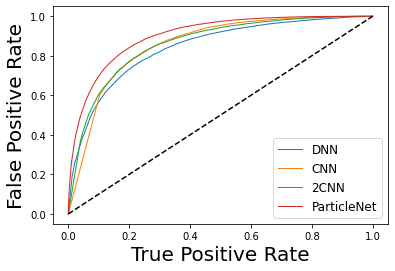

In [3]:
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/DNN/PR.h5", 'r')
tpr1 = hf["tpr"][()]
fpr1 = hf["fpr"][()]
hf.close()
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/CNN/PR.h5", 'r')
tpr2 = hf["tpr"][()]
fpr2 = hf["fpr"][()]
hf.close()
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/2CNN/PR.h5", 'r')
tpr3 = hf["tpr"][()]
fpr3 = hf["fpr"][()]
hf.close()
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/ParticleNet/PR.h5", 'r')
tpr4 = hf["tpr"][()]
fpr4 = hf["fpr"][()]
hf.close()


plt.plot(tpr1,fpr1, linewidth=1, label='DNN')
plt.plot(tpr2,fpr2, linewidth=1, label='CNN')
plt.plot(tpr3,fpr3, linewidth=1, label='2CNN')
plt.plot(tpr4,fpr4, linewidth=1, label='ParticleNet')
plt.legend(prop={'size': 12}) # plot label tag
plt.ylabel('False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.savefig("/home/ja2006203966/script/Network/data/H5/ALL_ROC.png")
plt.show()



In [40]:
it = iter([1, 2, 'continue', 4, 5])
for i in range(5):
    print("run",i)
    x = next(it)
    print(x)
#     except StopIteration:
#         pass
#     except 'continue':
#         continue

run 0
1
run 1
2
run 2
continue
run 3
4
run 4
5


# Prepare ParticleNet data

In [56]:
f = h5py.File("/home/ja2006203966/script/Network/data/H5/SVJ/rinv03/"+str(0)+"Trimjetc.h5",'r')

f.keys()

<KeysViewHDF5 ['ETA', 'JCDELTETA', 'JCDELTPHI', 'JCETA', 'JCMASS', 'JCPHI', 'JCPT', 'MASS', 'Ncontiteunts', 'PHI', 'PT', 'constiteunts_index', 'index']>

In [14]:
def jce_np(jcpt, jceta, jcmass):
    jcp = jcpt*np.cosh(jceta)
    return (jcp**2+jcmass**2)**0.5
    

In [17]:
_index, _jcpt, _jceta, _jcphi, _jcmass, _Ncons, _consindex, _jcdelteta, _jcdeltphi, _jpt, _jeta, _jphi = (i for i in range(12))
Labels = ['index', 'JCPT', 'JCETA', 'JCPHI', 'JCMASS', 'Ncontiteunts', 'constiteunts_index', 'JCDELTETA', 'JCDELTPHI', 'PT', 'ETA', 'PHI']
def h5_to_data(h5path):
    Data = {'mask':[], 'points':[], 'features':[]}
    f = h5py.File(h5path,'r')
    fc = np.array([f[lb][()] for lb in Labels])
    fc = fc.transpose((1,0))
    j0 = fc[0][_index]
    
    JCE = jce_np(fc[:,_jcpt], fc[:,_jceta], fc[:,_jcphi])
    logpt = np.log(fc[:,_jcpt])
    loge = np.log(JCE)
    relatpt = fc[:,_jcpt]/fc[:,_jpt]
    mask, features, points = np.zeros((100,1)), np.zeros((100,5)), np.zeros((100,2)) # prepare constituents list
    Nfc = len(fc)
    for j in range(len(fc)):
        if fc[j][_Ncons]>100:
            if j< Nfc-1:
                j0 = fc[j+1][_index]
            continue
        if fc[j][_index]!=j0:
            j0 = fc[j][_index]
            Data['mask'].append(mask)
            Data['points'].append(points)
            Data['features'].append(features)
            mask, features, points = np.zeros((100,1)), np.zeros((100,5)), np.zeros((100,2)) # prepare constituents list
            continue
        jc = int(fc[j][_consindex])
#         jce = JCE[j]
        
        points[jc] = np.array([fc[j][_jcdelteta], fc[j][_jcdeltphi] ])
        mask[jc] = logpt[j]
        features[jc] = np.array([logpt[j], loge[j], fc[j][_jcdelteta], fc[j][_jcdeltphi], relatpt[j]])
    return Data

def merging(gg,qq):
    total={}
    total['mask']=gg["mask"]+qq["mask"]
    total['features']=gg["features"]+qq["features"]
    total['points']=gg['points']+qq['points']
    return total
def separatedata(features_list,y,rateval,ratetest):
    features_train, features_test, features_val={},{},{}
    from sklearn.model_selection import train_test_split
    mask = features_list["mask"]
    features = features_list["features"]
    points = features_list["points"]
    X_ind = [i for i in range(len(y))]
    X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest)
    N=int(len(X_ind)*rateval/(rateval+ratetest))
    X_val, X_test = X_ind[:N], X_ind[N:]
    y_val, y_test = y_ind[:N], y_ind[N:]
    features_train['mask']=np.array([mask[i] for i in X_train])
    features_train['features']=np.array([features[i] for i in X_train])
    features_train['points']=np.array([points[i] for i in X_train])
    
    features_test['mask']=np.array([mask[i] for i in X_test])
    features_test['features']=np.array([features[i] for i in X_test])
    features_test['points']=np.array([points[i] for i in X_test])
    
    features_val['mask']=np.array([mask[i] for i in X_val])
    features_val['features']=np.array([features[i] for i in X_val])
    features_val['points']=np.array([points[i] for i in X_val])
    
    return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test) 

In [18]:
N=40
Jim = np.array([np.zeros((64,64))])
Data = {'mask':[], 'points':[], 'features':[]}
Data2 =  {'mask':[], 'points':[], 'features':[]}
for i in tqdm(range(N)):
    h5path1 = "/home/ja2006203966/script/Network/data/H5/SVJ/rinv03/"+str(i)+"Trimjetc.h5"
    h5path2 = "/home/ja2006203966/script/Network/data/H5/QCD/"+str(i)+"Trimjetc.h5"
    data = h5_to_data(h5path1)
    data2 = h5_to_data(h5path2)
    Data = merging(Data, data)
    Data2 = merging(Data2, data2)


    
        
        
                  
                  
    
    
  



100%|██████████| 40/40 [04:17<00:00,  6.44s/it]


In [19]:
print("check shape: ",Data['mask'][0].shape,Data['points'][0].shape,Data['features'][0].shape)

check shape:  (100, 1) (100, 2) (100, 5)


In [20]:
y=[[0,1] for i in range(len(Data['mask']))]+[[1,0] for i in range(len(Data2['mask']))] 
total = merging(Data, Data2)
# del gg, qq, eventg, eventq
# del Data, Data2
X_train, X_val, X_test, y_train, y_val, y_test = separatedata(total,y,0.3,0.1)

In [21]:
# outfile = "/home/ja2006203966/script/Network/data/H5/ParticleNet/Train.h5"
# hf = h5py.File(outfile, 'w')
# hf.create_dataset('X_train_mask', data=X_train['mask'])
# hf.create_dataset('X_val_mask', data=X_val['mask'])
# hf.create_dataset('X_test_mask', data=X_test['mask'])

# hf.create_dataset('X_train_points', data=X_train['points'])
# hf.create_dataset('X_val_points', data=X_val['points'])
# hf.create_dataset('X_test_points', data=X_test['points'])

# hf.create_dataset('X_train_features', data=X_train['features'])
# hf.create_dataset('X_val_features', data=X_val['features'])
# hf.create_dataset('X_test_features', data=X_test['features'])

# hf.create_dataset('y_train', data=y_train)
# hf.create_dataset('y_val', data=y_val)
# hf.create_dataset('y_test', data=y_test)
# hf.close()

In [3]:
outfile = "/home/ja2006203966/script/Network/data/H5/ParticleNet/Train.h5"
hf = h5py.File(outfile, 'r')
lb = ['mask', 'points', 'features']
X_train, X_val, X_test ={'mask':[], 'points':[], 'features':[]},{'mask':[], 'points':[], 'features':[]},{'mask':[], 'points':[], 'features':[]}
for i in lb:
    X_train[i] = hf["X_train_"+i][()]
    X_val[i] = hf["X_val_"+i][()]
    X_test[i] = hf["X_test_"+i][()]


y_train = hf["y_train"][()]
y_val = hf["y_val"][()]
y_test = hf["y_test"][()]

hf.close()

In [4]:
print([X_train[i][0].shape for i in lb])

[(100, 1), (100, 2), (100, 5)]


# ParticleNet

In [5]:
from tf_keras_model import get_particle_net

In [9]:
# input_shapes={'points': Data['points'][0].shape, 'features': Data['features'][0].shape, 'mask': Data['mask'][0].shape}
input_shapes={'points': X_train['points'][0].shape, 'features': X_train['features'][0].shape, 'mask': X_train['mask'][0].shape}

num_classes = 2
w = 0 ## weights you can choose (it is added by myself, and I use the 5-th as the weight term)
model = get_particle_net(num_classes, input_shapes, w=w, K=16)

# model = get_particle_net(num_classes, input_shapes, w=w)

In [10]:
# Training parameters
batch_size = 200
epochs = 200

In [24]:
# Prepare model model saving directory.
import os
model_type = "ParticleNet"
save_dir = '/home/ja2006203966/script/Network/data/H5/ParticleNet/'
model_name = '%s_model_test.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

# lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

# progress_bar = keras.callbacks.ProgbarLogger()
csv_logger = keras.callbacks.CSVLogger(save_dir+'ParticleNet.csv')
earlystop = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=1e-4,
                            patience=3,
                            verbose=1,
                            mode='min', baseline=None, ## 'min' 
                            restore_best_weights=True)
# callbacks = [checkpoint, lr_scheduler, progress_bar]
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)
# callbacks = [checkpoint, reduce_lr, csv_logger, progress_bar, earlystop ] ## [checkpoint, lr_scheduler, csv_logger, progress_bar, earlystop ]
callbacks = [checkpoint, csv_logger, earlystop ]


In [25]:
save_dir+'ParticleNet.csv'

'/home/ja2006203966/script/Network/data/H5/ParticleNet/ParticleNet.csv'

In [26]:
# train_dataset.shuffle()
model.fit(X_train ,y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=(X_val, y_val),
          shuffle=True ,
          callbacks=callbacks)
model.evaluate(X_test,  y_test, verbose=2)

Epoch 1/200
2138/2138 [==============================] - ETA: 0s - loss: 0.4561 - accuracy: 0.7851

[2020-08-04 10:05:25,404] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 433s 202ms/step - loss: 0.4561 - accuracy: 0.7851 - val_loss: 0.4342 - val_accuracy: 0.7971
Epoch 2/200
2138/2138 [==============================] - ETA: 0s - loss: 0.4226 - accuracy: 0.8063

[2020-08-04 10:12:38,009] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 432s 202ms/step - loss: 0.4226 - accuracy: 0.8063 - val_loss: 0.4265 - val_accuracy: 0.8022
Epoch 3/200
2138/2138 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.8132

[2020-08-04 10:19:50,169] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 432s 202ms/step - loss: 0.4104 - accuracy: 0.8132 - val_loss: 0.4809 - val_accuracy: 0.7839
Epoch 4/200
2138/2138 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.8169

[2020-08-04 10:27:02,084] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 432s 202ms/step - loss: 0.4045 - accuracy: 0.8169 - val_loss: 0.4142 - val_accuracy: 0.8109
Epoch 5/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3999 - accuracy: 0.8194

[2020-08-04 10:34:13,816] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 432s 202ms/step - loss: 0.3999 - accuracy: 0.8194 - val_loss: 0.4046 - val_accuracy: 0.8168
Epoch 6/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3972 - accuracy: 0.8210

[2020-08-04 10:41:25,378] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 431s 202ms/step - loss: 0.3972 - accuracy: 0.8210 - val_loss: 0.3938 - val_accuracy: 0.8238
Epoch 7/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3953 - accuracy: 0.8220

[2020-08-04 10:48:36,942] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 431s 202ms/step - loss: 0.3953 - accuracy: 0.8220 - val_loss: 0.3989 - val_accuracy: 0.8196
Epoch 8/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3931 - accuracy: 0.8240

[2020-08-04 10:55:48,517] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 431s 202ms/step - loss: 0.3931 - accuracy: 0.8240 - val_loss: 0.3926 - val_accuracy: 0.8238
Epoch 9/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3916 - accuracy: 0.8245

[2020-08-04 11:03:00,027] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 431s 202ms/step - loss: 0.3916 - accuracy: 0.8245 - val_loss: 0.3972 - val_accuracy: 0.8213
Epoch 10/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3905 - accuracy: 0.8251

[2020-08-04 11:10:11,369] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 431s 202ms/step - loss: 0.3905 - accuracy: 0.8251 - val_loss: 0.4209 - val_accuracy: 0.8095
Epoch 11/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.8261

[2020-08-04 11:17:22,866] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 431s 202ms/step - loss: 0.3888 - accuracy: 0.8261 - val_loss: 0.3899 - val_accuracy: 0.8255
Epoch 12/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3879 - accuracy: 0.8271

[2020-08-04 11:24:34,052] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 431s 202ms/step - loss: 0.3879 - accuracy: 0.8271 - val_loss: 0.4186 - val_accuracy: 0.8118
Epoch 13/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8270

[2020-08-04 11:31:44,197] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 430s 201ms/step - loss: 0.3869 - accuracy: 0.8270 - val_loss: 0.3904 - val_accuracy: 0.8248
Epoch 14/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3862 - accuracy: 0.8277

[2020-08-04 11:38:54,800] WARNING: Can save best model only with val_acc available, skipping.


Restoring model weights from the end of the best epoch.
2138/2138 [==============================] - 430s 201ms/step - loss: 0.3862 - accuracy: 0.8277 - val_loss: 0.3931 - val_accuracy: 0.8239
Epoch 00014: early stopping
2227/2227 - 41s - loss: 0.3892 - accuracy: 0.8245


[0.38920512795448303, 0.8244606852531433]

In [27]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pickle

In [41]:
LOSS0 = pd.read_csv('./myparticlenet_training_log.csv')
# label = []
# for i in LOSS0:
#     label.append(i)


In [28]:
model.save('./H5/ParticleNet/ParticleNet_f.h5')

The area under the curves are:
AUC:0.902108526


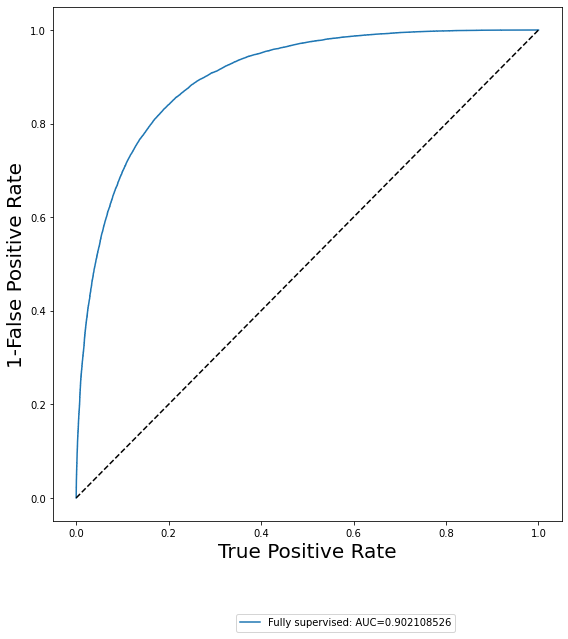

In [29]:
y_score=model.predict(X_test)[:,0]
test=[i[1] for i in y_test]
fpr , tpr , thresholds = roc_curve ( test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('1-False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("./H5/ParticleNet/Myneighnorhood_Particlenet_roc.png")
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/ParticleNet/PR.h5", 'w')
hf.create_dataset('fpr', data=fpr)
hf.create_dataset('tpr', data=tpr)
hf.close()

plt.show()

In [30]:
plt.figure(figsize=(8,8))
LOSS = pd.read_csv(save_dir)
# LOSS = pd.read_csv("/home/ja2006203966/script/Network/data/myparticlenet_training_log.csv")

plt.title("Learning Curve")
plt.plot(LOSS["loss"], label='loss',c='blue')
plt.plot(LOSS["val_loss"], label='val_loss',c='red')
plt.plot(LOSS["accuracy"], linestyle='--', label='accuracy',c='blue')
plt.plot(LOSS["val_accuracy"], linestyle='--', label='val_accuracy',c='red')
# plt.ylim([0.3,1])
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("/home/ja2006203966/script/Network/data/H5/ParticleNet/ParticleNetloss.png")

plt.show()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

<Figure size 576x576 with 0 Axes>

# Back up

In [ ]:
# y_test=[i[1] for i in testpojen_datay]
X_test = np.load("./X_test.npy",allow_pickle=True)
X_test = X_test.item()
y_test = np.load("./y_test.npy",allow_pickle=True)
y_score=model.predict(X_test)[:,0]
test=[i[1] for i in y_test]
fpr , tpr , thresholds = roc_curve ( test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('1-False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("./Myneighnorhood_Particlenet_roc.png")
np.save("./myfpr",fpr)
np.save("./mytpr",tpr)
#plt.close()
 
# plt.subplot(2,1,2) 
# LOSS = pd.read_csv('./training_log.csv')
# plt.plot(LOSS["loss"], label='loss',c='blue')
# plt.plot(LOSS["val_loss"], label='val_loss',c='red')
# plt.ylabel('loss',fontsize=20)
# plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
# plt.tight_layout()

#plt.savefig("./plot_3.png")
#plt.close()
plt.show()

# Papaer's CNN

In [ ]:
def data_generator(h5file1, h5file2, batchsize, hlindices, start=0, stop=None):
    stop = ((stop-start) // batchsize) * batchsize + start
    assert (stop-start) % batchsize     == 0  # Batches will not exceed stop.

    with h5py.File(h5file1, 'r') as f1, h5py.File(h5file2, 'r') as f2:
        assert f1['features'].shape[0] >= stop
        assert f1['features'].shape[0] == f1['targets'].shape[0]
        assert f1['features'].shape[0] == f2['features'].shape[0]
        assert f1['targets'].shape[0] == f2['targets'].shape[0]
        iexample = start
        
        while True:
            assert iexample >= start
            assert iexample+batchsize <= stop
            batch = slice(iexample, iexample + batchsize)

            X  = f1['features'][batch] # Images.
            Y  = f1['targets'][batch]
            #X2 = f2['features'][batch][:, hlindices] # High-level.
            #Y2 = f2['targets'][batch]  
            #assert np.all(Y == Y2)
            
            X = np.log(1.0+X) / 4.0 
            
            #yield X, Y
            #yield {'input_0':X, 'input_1':X2}, {'output':Y}
            yield {'input_0':X}, {'output':Y}
            
            iexample += batchsize
            if iexample >= stop:
                assert iexample == stop
                iexample = start
    

def train():
    ###############################################################################
    # Dataset                                                                     #
    ###############################################################################
    #filename = '/home/pjsadows//ml/data/physics/jets/download4/datasets/train_no_pile_10000000.h5'
    hlindices = np.array(['mass', 'c1b1']) # Order of features: mass, c1b1,c2b2,d1b2,d2b2, tau

    #filename  = '/Volumes/Free Space/images/train_no_pile_10000000.h5'
    #filename2 = '/Volumes/Free Space/highlevel/train_no_pile_10000000.h5'

    filename  = './train2_no_pile_10000000.h5' #image input
    filename2 = './train_no_pile_10000000.h5' #high level features input

    N_train, N_valid = 9500000, 500000
    generator = data_generator(filename, filename2, batchsize=100, hlindices=hlindices, start=0, stop=N_train)
    validation_data = data_generator(filename, filename2, batchsize=100, hlindices=hlindices, start=N_train, stop=N_train+N_valid)

    #filename_test  = '/Volumes/Free Space/images/test_no_pile_5000000.h5'
    #filename2_test = '/Volumes/Free Space/highlevel/test_no_pile_5000000.h5'

    filename_test  = './test2_no_pile_5000000.h5'
    filename2_test = './test_no_pile_5000000.h5'

    N_test = 5000000
    generator_test = data_generator(filename_test, filename2_test, batchsize=100, hlindices=hlindices, start=0, stop=N_test)

    ###############################################################################
    # Model                                                                       #
    ###############################################################################
    act  = 'relu' 
    init = 'glorot_normal' #'glorot_normal'#'he_normal'
    width = 500 #500 
    # Image arm
    nconv  = 4
    nch    = 32
    # Head
    nhead = 4
    ndo   = 2 
    
    # Arm 0: images
    input_0 = Input(shape=(1,32,32), dtype='float32', name='input_0') # We can name an layer by passing name.
    x0 = input_0
    for i in range(nconv):
        x0 = Convolution2D(nch,1, subsample=(1,1), border_mode='valid', init=init, activation=act)(x0) # nch, 4, 4
    x0 = Flatten()(x0) 

    # Arm 1: high-level variables.
    #input_1  = Input(shape=(len(hlindices),), name='input_1')
    #x1 = input_1
    #for i in range(nhl):
    #    x1 = Dense(width, init=init, activation=act)(x1)

    # Head
    #x = merge([x0, x1], mode='concat')
    x = x0
    for i in range(nhead):
        x = Dense(width, activation=act, init=init)(x)
        if i >= nhead - ndo:
            x = Dropout(p=0.5)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)

    # Model
    #model = Model(input=[input_0, input_1], output=[output])
    model = Model(input=[input_0], output=[output])
    lrinit  = 0.0001 
    lrdecay = 0.8
    optimizer = Adam(lr=lrinit, beta_1=0.99, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer,loss={'output':'binary_crossentropy'}, metrics=['accuracy'])

    ###############################################################################
    # Algorithm                                                                   #
    ###############################################################################
    def lr_scheduler(epoch):
        return lrinit * lrdecay ** epoch
    lrschedule = LearningRateScheduler(lr_scheduler)
    stopping   = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='min') 
    cbks = [stopping, lrschedule]

    # Copy script so that we can reconstruct model later.
    filebase = './images_conv%d_dense%d_nch%d_do%d_width%d_%s_lrd%d_%d' % (nconv, nhead, nch, ndo, width, act, lrdecay*100, np.random.randint(1000))
    fileout = filebase + '.py'
    os.system('cp %s %s' % (filebase, fileout))
    print('Saving to %s' % fileout)
    
    # Train.
    nb_epoch  = 1000
    history = model.fit_generator(generator, samples_per_epoch=N_train, nb_epoch=nb_epoch, verbose=1, validation_data=validation_data, nb_val_samples=N_valid, class_weight=None, callbacks=cbks) 

    # Save model.
    fileout = filebase + '.h5'
    model.save_weights(fileout, overwrite=True)
    # Save pkl.
    fileout = filebase + '.pkl'
    with open(fileout, 'w') as f:
        pickle.dump(history.history, f)
    # Save .yaml script.
    fileout = filebase + '.yaml'
    with open(fileout, 'w') as f:
        f.write(model.to_yaml())

    # Compute test error accuracy.
    vals = model.evaluate_generator(generator_test, val_samples=N_test, max_q_size=10)
    for name, val in zip(model.metrics_names, vals):
        print('test_%s: %f' % (name, val))
        history.history['test_' + name] = val
    # Compute AUC
    #auc = compute_auc(model, generator_test, val_samples=N_test)
    #print 'Test AUC: %f' % auc
    #history.history['test_auc'] = auc

    # Save pkl.
    fileout = filebase + '.pkl'
    with open(fileout, 'w') as f:
        pickle.dump(history.history, f)


    return history.history['val_loss'][-1]

# if __name__=='__main__':
#     loss = train()
#     print(loss)
